C:\Users\PLC Group\AppData\Local\Temp\ipykernel_24468\3811830363.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Zip Code'].fillna(df['Zip Code'].mode()[0], inplace=True)
C:\Users\PLC Group\AppData\Local\Temp\ipykernel_24468\3811830363.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

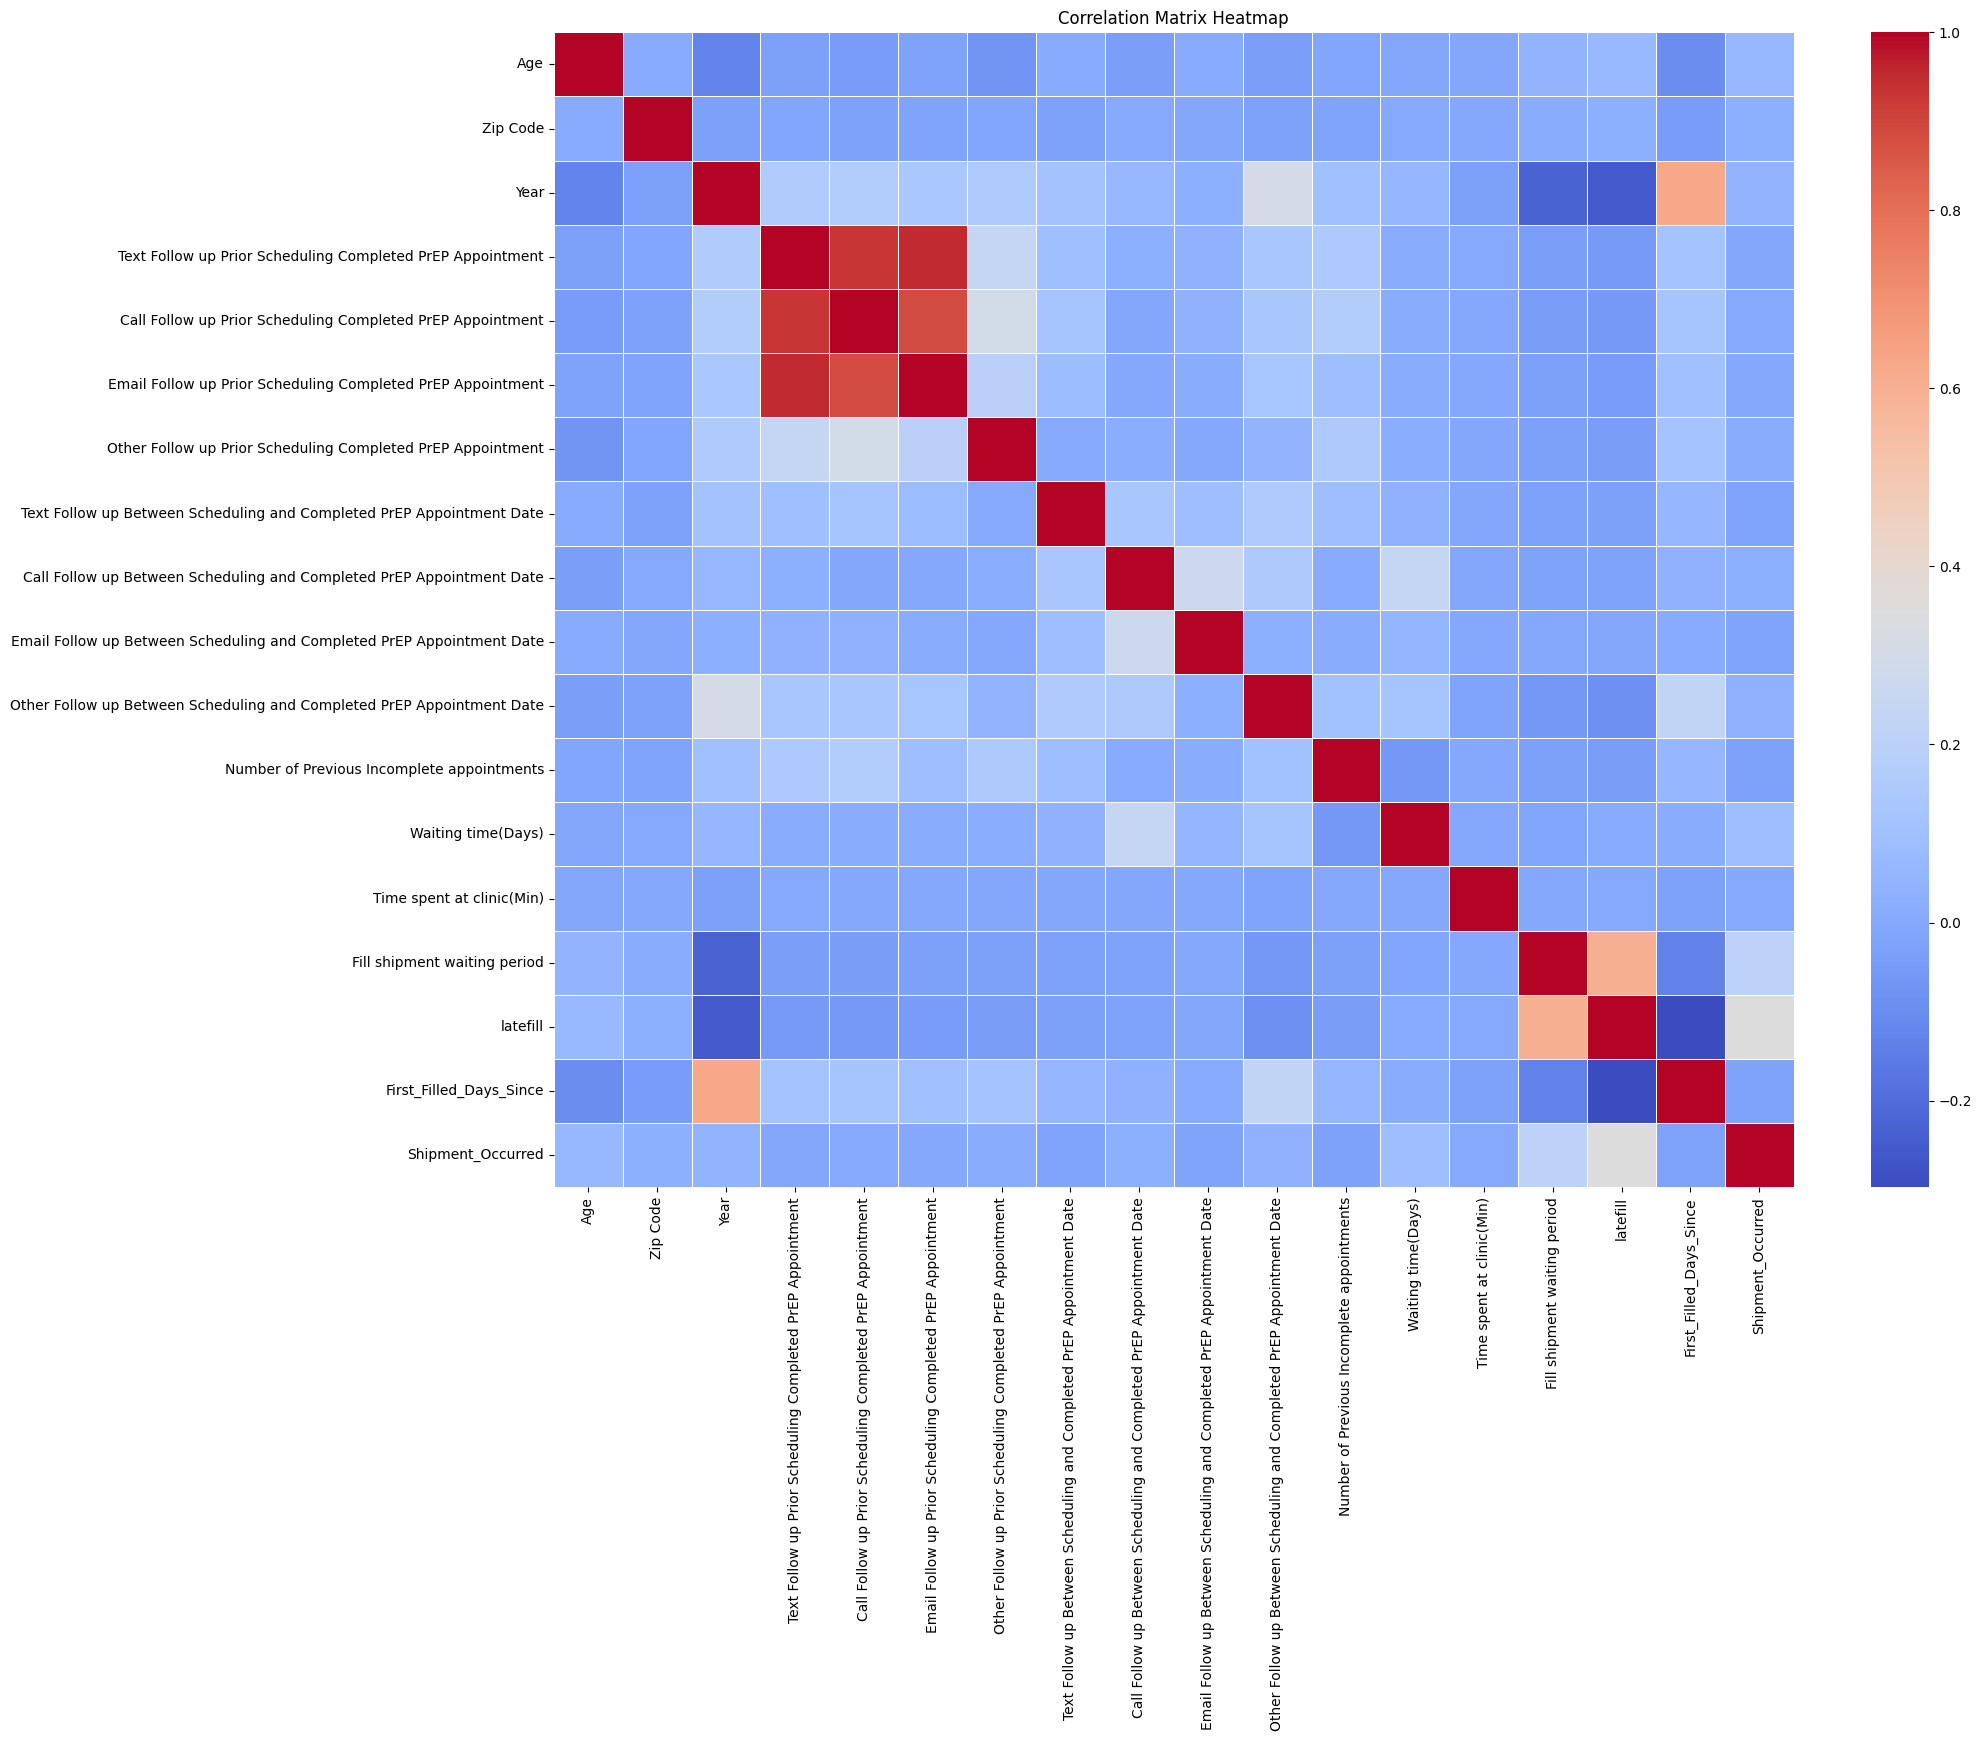

d:\Ahmad Uzzam\personal\Harsh\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


((Shipment_Occurred                                                         1.000000
  latefill                                                                  0.354403
  Fill shipment waiting period                                              0.208927
  Waiting time(Days)                                                        0.088627
  Age                                                                       0.065696
  Year                                                                      0.044044
  Other Follow up Between Scheduling and Completed PrEP Appointment Date    0.037778
  Zip Code                                                                  0.028533
  Call Follow up Between Scheduling and Completed PrEP Appointment Date     0.027188
  Other Follow up Prior Scheduling Completed PrEP Appointment               0.013621
  Name: Shipment_Occurred, dtype: float64,
  Call Follow up Between Scheduling and Completed PrEP Appointment Date     0.027188
  Other Follow up Prio

In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = '2206MCPC_VA (1).xlsx'
df = pd.read_excel(file_path)

# Fill missing values in 'Zip Code' and 'City'
df['Zip Code'].fillna(df['Zip Code'].mode()[0], inplace=True)
df['City'].fillna(df['City'].mode()[0], inplace=True)

# Fill missing values in 'Provider' with 'Unknown'
df['Provider'].fillna('Unknown', inplace=True)

# Fill missing values in 'Time spent at clinic(Min)' with the median
df['Time spent at clinic(Min)'].fillna(df['Time spent at clinic(Min)'].median(), inplace=True)

# Create a binary indicator for latefill
df['latefill'] = df['Fill shipment waiting period'].apply(lambda x: 1 if x > 30 else 0)

# Convert date columns to datetime format
df['First Completed PrEP Appointment Scheduled Date'] = pd.to_datetime(df['First Completed PrEP Appointment Scheduled Date'])
df['First Completed PrEP Appointment Date'] = pd.to_datetime(df['First Completed PrEP Appointment Date'])

# Add 'Appointment_Month' column
df['Appointment_Month'] = df['First Completed PrEP Appointment Date'].dt.month

# Convert 'First Filled Date After Completed Appointment' to datetime and create a new feature
df['First Filled Date After Completed Appointment'] = pd.to_datetime(df['First Filled Date After Completed Appointment'])
df['First_Filled_Days_Since'] = (df['First Filled Date After Completed Appointment'] - df['First Filled Date After Completed Appointment'].min()).dt.days

# Drop the original 'First Filled Date After Completed Appointment' column
df.drop(columns=['First Filled Date After Completed Appointment'], inplace=True)

# Convert 'Zip Code' to integer after filtering out non-digit characters
df['Zip Code'] = df['Zip Code'].apply(lambda x: int(''.join(filter(str.isdigit, str(x)))))

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=[
    'Age Group', 'Ethnicity', 'Race', 'Clinic assigned to', 'Telehealth type', 
    'Previous Incomplete appointments type', 'Provider', 'Timeslot', 
    'Day of week', 'Appointment_Month'
])

# Ensure 'Shipment_Occurred' is correctly created before encoding
df_encoded['Shipment_Occurred'] = df['First Shipped Date After Completed Appointment'].apply(
    lambda x: 1 if pd.notna(x) else 0
)

# Identify columns with non-numeric data that should be numeric
non_numeric_columns = df_encoded.select_dtypes(exclude=[np.number]).columns

# Drop the non-numeric columns that cannot be converted directly
df_encoded_cleaned = df_encoded.drop(columns=non_numeric_columns)

# Re-impute missing values for numeric columns
numeric_cols = df_encoded_cleaned.select_dtypes(include=[np.number]).columns
categorical_cols = df_encoded_cleaned.select_dtypes(exclude=[np.number]).columns

imputer_numeric = SimpleImputer(strategy='median')
df_encoded_cleaned[numeric_cols] = imputer_numeric.fit_transform(df_encoded_cleaned[numeric_cols])

# Fill missing values in categorical columns manually with the mode (most frequent value)
for column in categorical_cols:
    df_encoded_cleaned[column].fillna(df_encoded_cleaned[column].mode()[0], inplace=True)

# Separate majority and minority classes
df_majority = df_encoded_cleaned[df_encoded_cleaned['Shipment_Occurred'] == 1]
df_minority = df_encoded_cleaned[df_encoded_cleaned['Shipment_Occurred'] == 0]

# Perform oversampling on the minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=42) # reproducible results

# Combine majority class with upsampled minority class
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Define features (X) and target (y) after balancing
X_balanced = df_balanced.drop(columns=['Shipment_Occurred'])
y_balanced = df_balanced['Shipment_Occurred']

# Calculate the Pearson correlation coefficient for the features
corr_matrix = df_balanced.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

# Identify key features influencing the target variable (Shipment_Occurred)
target_corr = corr_matrix['Shipment_Occurred'].sort_values(ascending=False)
top_features = target_corr.head(10)  # Top 10 features most positively correlated with the target
bottom_features = target_corr.tail(10)  # Top 10 features most negatively correlated with the target

# Fit the RandomForest model
rf_balanced = RandomForestClassifier(random_state=42)
rf_balanced.fit(X_balanced, y_balanced)

# Calculate feature importances
importances_balanced = rf_balanced.feature_importances_
feature_importance_balanced = pd.Series(importances_balanced, index=X_balanced.columns)

# Sort features by importance
sorted_importance_balanced = feature_importance_balanced.sort_values(ascending=False)

# Perform feature selection using the RandomForest model
selector_balanced = SelectFromModel(rf_balanced, threshold='mean', prefit=True)
X_selected_balanced = selector_balanced.transform(X_balanced)

# Get the selected feature names
selected_features_balanced = X_balanced.columns[selector_balanced.get_support()]

(top_features, bottom_features), sorted_importance_balanced.head(10), selected_features_balanced.tolist()


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Fit the Logistic Regression model
logreg_balanced = LogisticRegression(random_state=42, max_iter=1000)
logreg_balanced.fit(X_balanced, y_balanced)

# Predict on the training data
y_pred_balanced = logreg_balanced.predict(X_balanced)

# Evaluate the model
conf_matrix = confusion_matrix(y_balanced, y_pred_balanced)
class_report = classification_report(y_balanced, y_pred_balanced)
accuracy = accuracy_score(y_balanced, y_pred_balanced)

conf_matrix, class_report, accuracy


(array([[8255,  402],
        [4491, 4166]]),
 '              precision    recall  f1-score   support\n\n         0.0       0.65      0.95      0.77      8657\n         1.0       0.91      0.48      0.63      8657\n\n    accuracy                           0.72     17314\n   macro avg       0.78      0.72      0.70     17314\nweighted avg       0.78      0.72      0.70     17314\n',
 0.7173963266720573)

In [3]:
# Neatly formatted classification report
formatted_class_report = classification_report(y_balanced, y_pred_balanced, target_names=['Class 0', 'Class 1'])

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", formatted_class_report)
print("Accuracy:", accuracy)


Confusion Matrix:
 [[8255  402]
 [4491 4166]]

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.65      0.95      0.77      8657
     Class 1       0.91      0.48      0.63      8657

    accuracy                           0.72     17314
   macro avg       0.78      0.72      0.70     17314
weighted avg       0.78      0.72      0.70     17314

Accuracy: 0.7173963266720573


Problems with Logistic Regression:

Linearity Assumption: Logistic regression assumes a linear relationship between the features and the log odds of the target variable. If the relationship is non-linear, logistic regression may not capture the complexity of the data well.

Sensitive to Outliers: Logistic regression can be sensitive to outliers, which can disproportionately affect the model's predictions.

Feature Independence: Logistic regression assumes that the features are independent of each other. If features are correlated (multicollinearity), it can lead to unstable estimates and reduced model performance.

Limited Model Complexity: Logistic regression is a relatively simple model and may struggle with complex datasets where decision boundaries are non-linear or involve intricate interactions between features.

Why RandomForest is Better:

Non-linear Relationships: RandomForest is an ensemble method that constructs multiple decision trees. It can capture complex, non-linear relationships in the data, making it more flexible than logistic regression.

Robust to Outliers: Since RandomForest uses multiple decision trees and aggregates their predictions, it is less sensitive to outliers compared to logistic regression.

Handles Feature Interactions: RandomForest can automatically handle interactions between features and does not require explicit feature engineering to capture these relationships.

Feature Importance: RandomForest provides a natural way to assess the importance of each feature, allowing you to understand which features contribute most to the model's predictions.

Less Sensitive to Multicollinearity: The ensemble nature of RandomForest reduces the impact of multicollinearity between features, leading to more stable predictions.

In [4]:
from sklearn.ensemble import RandomForestClassifier

# Fit the RandomForest model
rf_balanced = RandomForestClassifier(random_state=42, n_estimators=100)
rf_balanced.fit(X_balanced, y_balanced)

# Predict on the training data
y_pred_rf_balanced = rf_balanced.predict(X_balanced)

# Evaluate the model
conf_matrix_rf = confusion_matrix(y_balanced, y_pred_rf_balanced)
class_report_rf = classification_report(y_balanced, y_pred_rf_balanced)
accuracy_rf = accuracy_score(y_balanced, y_pred_rf_balanced)

conf_matrix_rf, class_report_rf, accuracy_rf


(array([[8657,    0],
        [   0, 8657]]),
 '              precision    recall  f1-score   support\n\n         0.0       1.00      1.00      1.00      8657\n         1.0       1.00      1.00      1.00      8657\n\n    accuracy                           1.00     17314\n   macro avg       1.00      1.00      1.00     17314\nweighted avg       1.00      1.00      1.00     17314\n',
 1.0)

In [5]:
from sklearn.model_selection import train_test_split

# Split the balanced dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Train the RandomForest model on the training set
rf_balanced_train = RandomForestClassifier(random_state=42, n_estimators=100)
rf_balanced_train.fit(X_train, y_train)

# Predict on the training set
y_pred_train = rf_balanced_train.predict(X_train)

# Predict on the test set
y_pred_test = rf_balanced_train.predict(X_test)

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_pred_train)
train_class_report = classification_report(y_train, y_pred_train)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
test_class_report = classification_report(y_test, y_pred_test)

train_accuracy, test_accuracy, train_class_report, test_class_report


(1.0,
 1.0,
 '              precision    recall  f1-score   support\n\n         0.0       1.00      1.00      1.00      6915\n         1.0       1.00      1.00      1.00      6936\n\n    accuracy                           1.00     13851\n   macro avg       1.00      1.00      1.00     13851\nweighted avg       1.00      1.00      1.00     13851\n',
 '              precision    recall  f1-score   support\n\n         0.0       1.00      1.00      1.00      1742\n         1.0       1.00      1.00      1.00      1721\n\n    accuracy                           1.00      3463\n   macro avg       1.00      1.00      1.00      3463\nweighted avg       1.00      1.00      1.00      3463\n')

In [6]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation on the balanced dataset
cv_scores = cross_val_score(RandomForestClassifier(random_state=42, n_estimators=100), X_balanced, y_balanced, cv=5, scoring='accuracy')

# Calculate mean and standard deviation of cross-validation scores
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

mean_cv_score, std_cv_score, cv_scores


(np.float64(0.9997112330349408),
 np.float64(0.0005775339301183903),
 array([1.        , 0.99855617, 1.        , 1.        , 1.        ]))